## Import packages

In [4]:
import pandas as pd
import math
import random
import numpy as np
import pylab as pl
import scipy.special as ss
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as st

np.random.seed(2035909)

# Intersection vector and sphere

The equation for a d-dimensional sphere, with center $(c_1,\ldots,c_d)$ we have for all points $(x_1,\ldots,x_d)$ $$\sum_{i=1}^{d} (x_i-c_i)^2 = r^2$$ In vector notation we get $$|P-C|^2 = r^2$$ where $C = (c_1,\ldots,c_d)$ is the center and $P = (x_1,\ldots,x_d)$ is a vector that fulfils the equation above. One point that is in this set $P$ is the intersection of our vector and the sphere. Let $$P(t) = x+t\cdot v$$ denote the equation of our vector. If we plug in this equation in the equation above and solve for $t$, we find the time until the vector intersects with the sphere (if the intersection exists). Thus, 

$$
\begin{align}
0 & = |P-C|^2 - r^2 \\
& = |x+t\cdot v-C|^2 - r^2 \\
& = (x+t\cdot v-C)\bullet (x+t\cdot v-C) - r^2 \\
& = t^2 v\bullet v + t(2\cdot x\bullet v - 2\cdot C\bullet v) + x\bullet x + C\bullet C - 2\cdot x\bullet C - r^2 \\
& = t^2\big(v\bullet v\big) + t\big(2\cdot (v\bullet(x-C))\big) + (x-C)\bullet(x-C) - r^2
\end{align}
$$

where $\bullet$ denotes the standard inproduct. Now, this is a simple polynomial equation that we can solve for $t$. 

Define $D = \big(2\cdot (v\bullet(x-C))\big)^2 - 4\cdot \big(v\bullet v\big) \cdot \big((x-C)\bullet(x-C) - r^2\big)$. If $D<0$ there are no solutions and there will be no intersections between the vector and the sphere. If $D=0$ there is only one solution, namely $$t_{*} = -\frac{v\bullet(x-C)}{v\bullet v}$$ and if $D>0$ there are two solutions. However, we are looking for the smallest. Hence, $$t_{*} = \text{min}\Big(\frac{-2\cdot (v\bullet(x-C))+\sqrt{D}}{2\cdot v\bullet v},\frac{-2\cdot (v\bullet(x-C))-\sqrt{D}}{2\cdot v\bullet v}\Big)$$

The normal at the intersecting point is exactly the vector $x+t_{*}\cdot v - C$.

In [302]:
def tau_bounce_sphere(x,v,r,C):
    D = (2*(np.dot(v,x-C)))**2 - 4*np.dot(v,v)*(np.dot(x-C,x-C)-r**2)
    if (D<0):
        tau = np.nan
    elif (D==0):
        tau = -(np.dot(v,x-C))/(np.dot(v,v))
    else:
        tau = min((-2*np.dot(v,x-C) + np.sqrt(D))/(2*np.dot(v,v)),(-2*np.dot(v,x-C) - np.sqrt(D))/(2*np.dot(v,v)))
    return tau

# Bouncy sampler

### Class BPS

In [34]:
def random_time(a,b,y):
    if b == 0:
        if a > 0:
            return np.log(y)/(-float(a))
        else:
            return -1
    elif b > 0:
        if a >= 0:
            return -a/float(b) + np.sqrt(a**2/float(b**2) - 2*np.log(y)/float(b))
        else:
            return -a/float(b) + random_time(0,b,y)
    else:
        if a > 0:
            if np.log(y) >= a**2/float(2*b):
                return -a/float(b) - np.sqrt(a**2/float(b**2) - 2*np.log(y)/float(b))
            else:
                return -1
        else:
            return -1

In [35]:
def resample_velocity(dim):
    mean = [0]*dim
    cov = np.eye(dim)
    return np.random.multivariate_normal(mean,cov)

In [36]:
def flip_BPS(x,v,mu,V):
    gradient = np.dot(V,(x-mu))
    return v-2*((np.dot(v,gradient))/float((np.dot(gradient,gradient))))*gradient

In [37]:
def reflection(v,n):
    """Return specular reflection"""
    return v-2*(np.dot(v,n)/float((np.dot(n,n))))*n

In [38]:
def normal_sphere(x_hit,C):
    """Return normal for incoming vector on sphere"""
    return x_hit-C

In [39]:
class BPS:
    def __init__(self,x0,dim,mu,V,final_time,boundary = np.array([[0,0],1])):
        self.dim = dim
        self.x0 = x0
        self.mu = mu
        self.V = V
        self.final_time = final_time
        self.boundary = boundary
        self.simulation = self._simulation()

    def description(self):
        print "We are trying to sample from a normal distribution in", self.dim, "-d, with mean", self.mu, "and variance", self.V
        
    def _simulation(self): 
    
        # Control the total time
        current_time = 0

        # Initialize dataframes
        T = pd.DataFrame(columns = ['T'])
        X = pd.DataFrame(columns = range(self.dim))
        theta = pd.DataFrame(columns = range(self.dim))

        # Initial values
        T.loc[1] = 0
        X.loc[1,] = self.x0#[0]*self.dim
        theta.loc[1,] = resample_velocity(self.dim)

        # Define the refresh rate
        refresh_rate = 1
        bounce = -1
        k = 1
        bound = np.nan

        while (current_time < self.final_time):

            # Draw uniform r.v. for switching time, refresh time and acceptance of new switching time
            R = np.random.uniform(0,1,[1,2])
            a = np.dot(theta.loc[k,:].values,np.dot(self.V,X.loc[k,:].values-self.mu))
            b = np.dot(theta.loc[k,:].values,np.dot(self.V,theta.loc[k,:].values))
            bounce = random_time(a,b,R[0,0])
            #print('bounce',bounce)
            
            if self.boundary is not None:
                #print('x',X.loc[k,:])
                #print('v',theta.loc[k,:])
                bound = tau_bounce_sphere(X.loc[k,:],theta.loc[k,:],self.boundary[1],self.boundary[0])
                if bound<0:
                    bound = np.nan
                    
            if (refresh_rate <= 0):
                refresh = -1
                print('Infinity')
                tau = bounce
            else:
                refresh = -np.log(R[0,1])/float(refresh_rate)
                #print('refresh',refresh)
                tau = np.nanmin([bounce,refresh,bound])
            
            #print(tau)
            # Update time and path
            T.loc[k+1] = T.loc[k] + tau
            X.loc[k+1,:] = X.loc[k,:] + theta.loc[k,:]*tau
            #theta.loc[k+1,:] = theta.loc[k,:]
            #print(X.loc[k+1,:])
            
            #print('Old v',theta.loc[k,:])
            if tau == refresh: # refresh
                theta.loc[k+1,:] = resample_velocity(self.dim)
            elif tau == bound: # bound
                n = normal_sphere(X.loc[k+1,:],self.boundary[0])
                #print('n',n)
                theta.loc[k+1,:] = reflection(theta.loc[k,:],n)
                #print('New v',theta.loc[k+1,:])
            else: # bounce
                theta.loc[k+1,:] = flip_BPS(X.loc[k+1,:].values,theta.loc[k,:].values,self.mu,self.V)
            
            k = k+1
            current_time = T.loc[k].item()

        return T,X,theta
    
    def mean_and_covariance(self):
        T,X,theta = self.simulation
        d = X.shape[1]
        n_points = T.shape[0]

        k = 2
        means = np.zeros(d)
        covariance = np.zeros((d,d))
        T_max = T.loc[n_points,'T']

        t_prev= T.loc[k-1,'T']
        x_prev= X.loc[k-1,:].values

        while k <= n_points:
            t_now = T.loc[k,'T']
            x_now = X.loc[k,:].values

            means = means + (t_now-t_prev)*(x_prev+x_now)/(float(2)*T_max)
            covariance = covariance + (t_now-t_prev)*((1/(float(6)*T_max))*(2*np.multiply.outer(x_now,x_now) + np.multiply.outer(x_now,x_prev) + np.multiply.outer(x_prev,x_now) + 2*np.multiply.outer(x_prev,x_prev)))
            t_prev = t_now
            x_prev = x_now
            k = k+1

        covariance = covariance - np.multiply.outer(means,means)

        return means, covariance
    
    def plot_path(self):
        fig, ax = plt.subplots()
        T,X,theta = self.simulation
        if self.dim == 1:
            plt.xlabel('t')
            plt.ylabel('X')
            plt.plot(T,X)
        elif self.dim == 2:
            plt.xlabel('X1(t)')
            plt.ylabel('X2(t)')
            plt.plot(X.loc[:,0], X.loc[:,1])
            
        circ=plt.Circle(self.boundary[0], radius=self.boundary[1],fill=False)
        ax.add_patch(circ)
        plt.axis('equal')
        
        plt.grid(True)
        plt.show()
        
    def sample_traj(self,m):
        T,X,theta = self.simulation
        n_points = T.shape[0]-1
        tau = T.loc[n_points,'T']
        dim = X.shape[1]
        sample = pd.DataFrame(columns = range(dim))

        for i in range(1,m):
            t = i*tau/m
            index = np.argmax(T.loc[:,'T']>t)-1
            traj = X.iloc[index,:].values+(t-(T.loc[index,'T']))*np.int64(theta.iloc[index,:].values)
            sample.loc[i,:] = traj
        return sample

### Examples

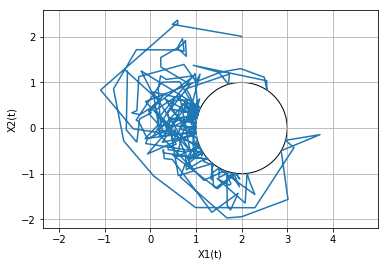

In [158]:
np.random.seed(134304)
%matplotlib inline
bps = BPS([2,2],2,np.array([1,0]),np.array([[3,1],[1,3]]),100,boundary = np.array([[2,0],1]))
bps.plot_path()

In [279]:
np.random.seed(23050)
bps = BPS([2,2,2],3,np.array([0,0,0]),np.array([[1,0,0],[0,1,0],[0,0,1]]),100,boundary = np.array([[0,0,0],0.01]))
_,X,_ = bps.simulation

<IPython.core.display.Javascript object>


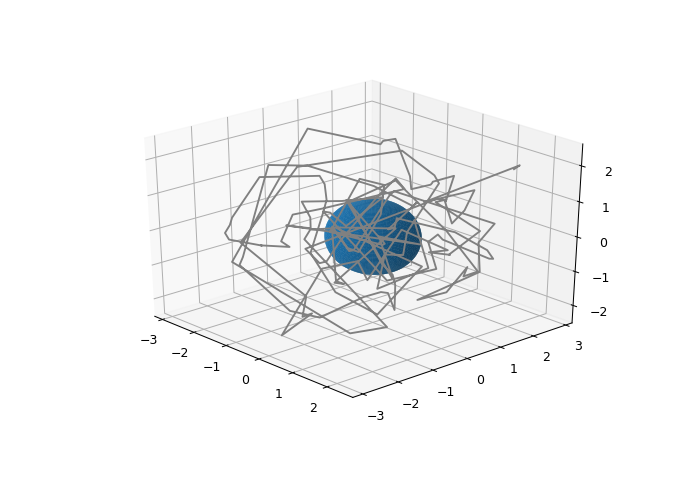

In [280]:
%matplotlib notebook
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

ax.plot3D(X[0], X[1], X[2], 'gray')

# Data for three-dimensional sphere
u = np.linspace(0, 2 * np.pi, 80)
v = np.linspace(0, np.pi, 80)

# create the sphere surface
x = 1 * np.outer(np.cos(u), np.sin(v)) - 0
y = 1 *np.outer(np.sin(u), np.sin(v)) - 0 
z = 1 * np.outer(np.ones(np.size(u)),np.cos(v)) - 0

ax.plot_surface(x, y, z, cstride=1, rstride=1)

plt.show()

# Estimation probabilities outside n-ball

## Bouncy

### Algorithm

In [28]:
def p_estimation_mnorm(N,T,q,mean,cov,Phi):
    
    st = time.time()
    dim = mean.size

    m=1
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    L_max = phi[0]
    #print(phi)
    ed = time.time()
    #print(ed-st)

    while L < q:   # as long as there are particles below q
        x0 = X[np.random.randint(2,N)]

        # Run a Markov chain on the lowermost sample
        st = time.time()
        bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,L]))
        _,process,_ = bps.simulation
        ed = time.time()
        #print('Markov chain takes',ed-st)
        
        x_star = [item for sublist in process.tail(1).values for item in sublist]

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        L_max = max(L,L_max)
        #print(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m

### Example -- distance from origin

In [84]:
def Phi_norm(x):
    """ Phi(x): R^d -> R"""
    return np.array([(np.dot(v,v)) for v in x])

In [526]:
N=100  # number of particles 
T=20   # number of MCMC steps
q=4   # quantile

In [409]:
# Targeting normal distribution with mean 0 and variance 1
mean = np.array([0])
cov = np.array([[1]])

p1 = p_estimation_mnorm(N,T,q,mean,cov,Phi_norm)

In [337]:
# Targeting multivariate normal distribution with mean [0,0] and variance [[1,0],[0,1]]
mean = np.array([0,0])
cov = np.array([[1,0],[0,1]])

p2 = p_estimation_mnorm(N,T,q,mean,cov,Phi_norm)

In [432]:
# Targeting multivariate normal distribution with mean M and covariance matrix cov
mean = np.array([0,0,0])
cov = np.array([[1,0,0],[0,1,0],[0,0,1]])

p3 = p_estimation_mnorm(N,T,q,mean,cov,Phi_norm)

In [528]:
print 'In 1 dimension:',p1
print 'In 2 dimensions:',p2
print 'In 3 dimensions:',p3

In 1 dimension: 6.71809336629e-05
In 2 dimensions: 0.000406018855156
In 3 dimensions: 0.00276836936186


In [24]:
from scipy.stats import chi
print 'In 1 dimension:',chi.sf(q,df=1)
print 'In 2 dimensions:',chi.sf(q,df=2)
print 'In 3 dimensions:',chi.sf(q,df=3)

 In 1 dimension: 6.33424836662e-05
In 2 dimensions: 0.000335462627903
In 3 dimensions: 0.00113398428979


In [341]:
mean = np.array([0]*5)
cov = np.array([[5,1,1,1,1],
                [1,5,1,1,1],
                [1,1,5,1,1],
                [1,1,1,5,1],
                [1,1,1,1,5]])

p4 = p_estimation_mnorm(N,T,q,mean,cov,Phi_norm)

In [342]:
p4

0.019453434285172516

### Example -- normalized correlation

In [329]:
def tau_bounce_cone(x,v,A,C):
    a = np.matmul(np.matmul(D.T,A),D)
    b = np.matmul(np.matmul(D.T,A),x-C)+np.matmul(x.T-C.T,np.matmul(A,v))
    c = np.matmul(np.matmul(x.T-C.T,A),O)+np.matmul(np.matmul(C.T-x.T,A),C)-1
    D = b**2 - 4*a*c
    if (D<0):
        tau = np.nan
    elif (D==0):
        tau = -(b)/(2*a)
    else:
        tau = min((-b+np.sqrt(D))/(2*a),(-b-np.sqrt(D))/(2*a))
    return tau

In [314]:
from random import gauss

def make_rand_vector(dims):
    vec = [np.random.normal(0,1) for i in range(dims)]
    mag = np.linalg.norm(vec)
    return vec/mag

In [519]:
np.random.seed(234089)
u = make_rand_vector(5)

In [500]:
def Phi_corr(x):
    return np.array([np.abs(np.dot(v,u))/(np.sqrt(np.dot(v,v))) for v in x])

In [520]:
N=100  # number of particles 
T=20   # number of MCMC steps
q=0.9   # quantile

In [522]:
# Targeting multivariate normal distribution with mean M and covariance matrix cov
dim = 5
mean = np.array([0]*dim)
cov = np.eye(dim)

#p_hat = p_estimation_mnorm(N,T,q,mean,cov,Phi_corr)

In [523]:
p_hat

5.1869627196641576e-36

## MH

### MH-algorithm

In [464]:
def mh_sampler(x0,target_fn,prop_fn,Phi,L,iterations = 100,target_fn_kwargs={},prop_fn_kwargs = {}):
    """Simple metropolis hastings.
    
    Arguments:
    x0: starting point of the chain
    target_fn: target p.d.f.
    prop_fn: proposal p.d.f.
    target_fn_kwargs: extra arguments for target function
    prop_fn_kwargs: extra arguments for proposal function
    L: bound to cross 
    iterations: number of mcmc iterations
    
    Returns:
    A Markov chain on the lowermost sample
    
    """
    dim = x0.size
    
    # Initialize chain, acceptance rate
    chain = np.zeros((iterations,dim))
    accept_rate = np.zeros(iterations)
    target = np.zeros((iterations,dim))
    
    random_uniform = np.random.uniform(0,1,iterations)
    
    # First samples
    chain[0,:] = x0
    target0 = target_fn(x0,**target_fn_kwargs)
    target[0,:] = target0
    
    naccept = 0
    for i in range(1,iterations):
        
        # propose
        x_star, factor = prop_fn(x0,**prop_fn_kwargs)
        
        # hastings-ratio
        target_star = target_fn(x_star,**target_fn_kwargs)
        H = (target_star/float(target0)) * factor

        # accept/reject step
        if (random_uniform[i] < H) & (Phi([x_star]) > L):
            x0 = x_star
            target0 = target_star
            naccept += 1
            #print(Phi([x_star]),L)
        
        # update chain
        chain[i,:] = x0
        target[i,:] = target0
        accept_rate[i] = naccept/float(i)
    
    return chain, accept_rate, target

In [44]:
def gaussian_proposal(x,cov):
    # Draw x_star
    x_star = np.random.multivariate_normal(x, cov)
    # x_star = x + np.random.randn()*sigma
    
    # proposal ratio factor
    factor = 1
    return x_star, factor

In [45]:
def normal(x,mu,cov):
    return np.exp(-0.5*(np.matmul(np.matmul((x-mu).T,cov),x-mu)))

### Algorithm

In [465]:
def p_estimation(N,T,q,target_fn,prop_fn,Phi,target_fn_kwargs,prop_fn_kwargs):

    m=1
    mean = target_fn_kwargs['mu']
    cov = target_fn_kwargs['cov']
    dim = mean.size
    X=np.random.multivariate_normal(mean,cov,N)
    phi=Phi(X)
    s = np.argsort(phi)
    phi,X = phi[s], X[s]
    X = np.array(X)
    L=phi[0]
    L_max = phi[0]
    #print(phi)

    while L < q:   # as long as there are particles below q
        x0 = X[np.random.randint(2,N)]
        
        # Run a Markov chain on the lowermost sample
        process,_,_ = mh_sampler(x0 = x0,
               target_fn = target_fn,
               prop_fn = prop_fn,
               Phi = Phi,
               L = L,
               iterations = T,
               target_fn_kwargs = target_fn_kwargs,
               prop_fn_kwargs = prop_fn_kwargs)
        
        #print(process)
        x_star = process[-1]

        # Update X
        X[0] = np.array(x_star)
        phi=Phi(X)
        s = np.argsort(phi)
        phi,X = phi[s], X[s]
        X = np.array(X)
        #phi = np.array(phi)
        
        # Set adaptive boundary
        L = phi[0]
        m = m + 1
        #L_max = max(L,L_max)
        #print(L)

    phat = (1.0-1.0/N)**(m-1)
    return phat,m

### Example -- distance from origin

In [16]:
N = 100
T = 20
q = 4

In [52]:
# Targeting normal distribution with mean 0 and variance 1
cov_prop = np.array([[2]])
mu_target = np.array([0])
cov_target = np.array([[1]])

p_1 = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, target_fn_kwargs = {'mu':mu_target,'cov':cov_target},prop_fn_kwargs = {'cov':cov_prop})

In [55]:
# Targeting normal distribution with mean [0,0] and variance [[1,0],[0,1]]
cov_prop = 2*np.eye(2)
mu_target = np.array([0]*2)
cov_target = np.eye(2)

p_2 = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, target_fn_kwargs = {'mu':mu_target,'cov':cov_target},prop_fn_kwargs = {'cov':cov_prop})

In [57]:
cov_prop = 2*np.eye(3)
mu_target = np.array([0]*3)
cov_target = np.eye(3)

p_3 = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, target_fn_kwargs = {'mu':mu_target,'cov':cov_target},prop_fn_kwargs = {'cov':cov_prop})

In [58]:
print 'In 1 dimension:',p_1
print 'In 2 dimensions:',p_2
print 'In 3 dimensions:',p_3

In 1 dimension: (0.0071925112092996, 492)
In 2 dimensions: (0.006124119562845145, 508)
In 3 dimensions: (0.0071925112092996, 492)


In [25]:
print 'In 1 dimension:',chi.sf(q,df=1)
print 'In 2 dimensions:',chi.sf(q,df=2)
print 'In 3 dimensions:',chi.sf(q,df=3)

In 1 dimension: 6.33424836662e-05
In 2 dimensions: 0.000335462627903
In 3 dimensions: 0.00113398428979


### Example -- normalized correlation

In [515]:
N = 100
T = 20
q = 0.95
np.random.seed(234089)
u = make_rand_vector(10)

cov_prop = 4*np.eye(10)
mu_target = np.array([0]*10)
cov_target = np.eye(10)

p_4 = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_corr, target_fn_kwargs = {'mu':mu_target,'cov':cov_target},prop_fn_kwargs = {'cov':cov_prop})

In [517]:
p_4

9.734028306796821e-80

## Compare methods

### Complexity

In the paper by Guyader they established that the expected computational complexity of the algorithm is $\mathcal{O}(N\ \text{log}\ N\ \text{log}\ p^{-1})$. The algorithm does not suffer from an increase in dimensionality since the $T$ proposed kernel transitions via the Metropolis-Hastings algorithm have lower complexity, namely $\mathcal{O}(1)$, than the dichotomic search and the insertion of the new particle at the right place in the ordered sample, whose cost in in $\mathcal{O}(\text{log}\ N)$ via a min-heap algorithm. This changes when we don't use Metropolis-Hastings, but the Bouncy Particle Sampler. 

The expected computational complexity of creating a path for the BPS is $\mathcal{O}(d)$, where $d$ denotes the dimension of the probability density function where we try to sample from. This can be seen in the following figure. As the dimension increases, the time complexity increases linearly for the Bouncy Particle Sampler and stays the same for Metropolis Hastings, independent of the dimension of the problem. For the figure below, we used 100 particles ($N=100$), 20 as the timespan for BPS and 20 iterations for MH. If it wasn't for the boundary- and refresh times, we would have on average 20 iterations for BPS. With these times we will produce more iterations than MH, but it is in the same order of magnitude.

In [32]:
import time

#### Time complexity BPS and MH

In [186]:
columns = ['time_bs','time_mh']
dimension = range(1,31)

df_tc = pd.DataFrame(index = dimension, columns = columns)
df_tc = df_tc.fillna(0)

N = 100
T = 20
L = 1

for i in range(0,len(dimension)):
    dim = dimension[i]
    x0 = np.array([2]*dim)
    mean = np.array([0]*dim)
    cov = np.eye(dim)
    cov_prop = 2*np.eye(dim)
    
    # Time complexity bouncy sampler
    start_bs = time.time()
    bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,L]))
    _,process_bs,_ = bps.simulation
    end_bs = time.time()

    # Time complexity mh sampler
    start_mh = time.time()
    process_mh,_,_ = mh_sampler(x0 = x0, target_fn = normal,
               prop_fn = gaussian_proposal, Phi = Phi_norm, L = L, iterations = T,
               target_fn_kwargs = {'mu':mean,'cov':cov},
               prop_fn_kwargs = {'cov':cov_prop})
    end_mh = time.time()
    
    # Update results
    df_tc.iloc[i,0] = end_bs-start_bs
    df_tc.iloc[i,1] = end_mh-start_mh
    

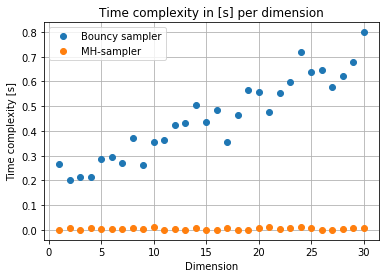

In [187]:
plt.grid(True, which="both")

plt.plot(dimension,df_tc['time_bs'],'o',label = 'Bouncy sampler')
plt.plot(dimension,df_tc['time_mh'],'o',label = 'MH-sampler')
plt.title('Time complexity in [s] per dimension')
plt.xlabel('Dimension')
plt.ylabel('Time complexity [s]')
plt.legend(loc='best')

plt.show()

This difference in complexity for a simple run of both algorithm causes a large difference in computation time if we want to estimate rare event probabilities. For a fixed $N$, say $N=100$, we are interested in a rare event probability $ p = 10^{-5}$. In that case we need approximately 
$$m = \frac{\text{log}(p)}{\text{log}(1-\frac{1}{N})} \approx 1000$$ iterations. This is regardless of the choice for BPS or MH. 

The algorithm for the estimation of the rare event probability is the same for both methods, except for the way we find our next point and here we find our difference in time.

Suppose we work in 1 dimension, the cheapest case for BPS, it takes on average 0.3 seconds to get a new event. For MH it takes on average 0.004 seconds. As long as we need as many iterations for BPS as MH, MH is always faster. In this case the behaviour will change if we need 75 iterations in MH for   Thus, in total we need over 5 minutes to produce an estimate for the BPS. Now, for MH, we only need 3 seconds. 

The difference in time is demonstrated in the table below.

In [190]:
np.random.seed(205090)

N = 100
T = 20
q = 4
target_fn = normal
prop_fn = gaussian_proposal

columns = ['p','p_est_bs','time_bs','n_bs','p_est_mh','time_mh','n_mh']
dimension = range(1,6)

df = pd.DataFrame(index = dimension, columns = columns)
df = df.fillna(0)

for i in range(0,len(dimension)):
    cov_prop = 2*np.eye(dimension[i])
    mu_target = np.array([0]*dimension[i])
    cov_target = np.eye(dimension[i])
    
    
    # Time complexity mh-sampler
    start_mh = time.time()
    p_mh,m_mh = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, 
                                target_fn_kwargs = {'mu':mu_target,'cov':cov_target},
                                prop_fn_kwargs = {'cov':cov_prop})
    end_mh = time.time()
    
    # Time complexity bouncy-sampler
    start_bs = time.time()
    p_bs,m_bs = p_estimation_mnorm(N,T,q,mu_target,cov_target,Phi_norm)
    end_bs = time.time()
    
    df.iloc[i,0] = chi.sf(q,df = dimension[i])
    
    df.iloc[i,1] = p_bs
    df.iloc[i,2] = end_bs - start_bs
    df.iloc[i,3] = m_bs
    
    df.iloc[i,4] = p_mh
    df.iloc[i,5] = end_mh - start_mh
    df.iloc[i,6] = m_mh

In [191]:
df

,p,p_est_bs,time_bs,n_bs,p_est_mh,time_mh,n_mh
1,0.000063,0.000044,334.254,999,0.000044,2.315,1000
2,0.000335,0.000638,271.569,733,0.000692,1.887,725
3,0.001134,0.001440,242.549,652,0.000983,1.782,690
4,0.003019,0.005009,186.918,528,0.002659,1.539,591
5,0.006844,0.009626,171.720,463,0.006312,1.301,505


The difference in performance, i.e. estimating the probability of a rare event, is also in favor of the MH-sampler.

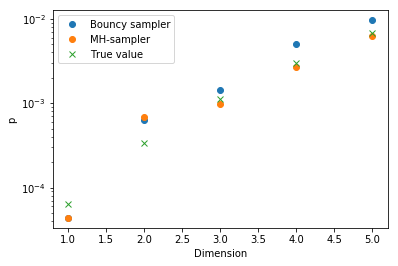

In [207]:
dimension = range(1,6)
plt.plot(dimension,df['p_est_bs'],'o',label = 'Bouncy sampler')
plt.plot(dimension,df['p_est_mh'],'o',label = 'MH-sampler')
plt.plot(dimension,df['p'],'x',label = 'True value')
plt.legend(loc='best')
plt.yscale('log')

plt.xlabel('Dimension')
plt.ylabel('p')

plt.show()

We can visualize the acceptance rate of the MH-algorithm. As the dimension increases, the probability of being outside the sphere increases. Remember that we choose $\Phi(X) = \lVert{X}\rVert$, to work with the distance from the origin to any $d$-sphere. However, it might be beneficial to switch to $\Phi(X) = \lVert{X}\rVert^2 = \sum_{i=1}^d x_i^2$. As long as $x_i, i=1,\ldots,d$ are uncorrelated we know that $Y_d = \Phi(X)$ follows a chi-squared distribution with $d$ degrees of freedom, i.e. $Y_d \sim \chi_d^2$. This is a more common probability density function with convenient properties. We can approximate this distribution $Y_d$ by a normal distribution, due to the Central Limit Theorem (independent random variables). To do this we need the expectation and variance of $Y_d$, so $$\mathbb{E}(Y_d) = \sum_{i=1}^d \mathbb{E}({X_i^2}) = d \cdot 1 = d$$ and 

$$
\begin{align}
\text{Var}(Y_d) & = \text{Var}\big(\sum_{i=1}^{d} X_i^2 \big) = d \cdot \text{Var}(X_1^2) \\
& = d\cdot (\mathbb{E}(X^4) - (\mathbb{E}(X^2))^2) = d\cdot (3-1) = 2d
\end{align}
$$ Then

$$\mathbb{P}(Y_d > L) = \mathbb{P}\Big(\frac{Y_d-d}{\sqrt{2d}} > \frac{L-d}{\sqrt{2d}}\Big) = \mathbb{P}\Big(Z>\frac{L-d}{\sqrt{2d}}\Big) (*)$$

So for fixed $L$ this probability is indeed increasing for increasing dimension, since $d$ grows faster than $\sqrt{2d}$.


Nevertheless, the acceptance rate for MH decreases. This means for high dimensions we need a lot of simulations to reach a new point, which may be beneficial for the BPS, since it requires only one run to find a new point. Suppose we start in a point $x_0$, then our proposal is of the form $x_1 = x_0 + \sigma Z_d$, where $Z_d$ denotes the $d$-dimensional multivariate normal distribution. If we have a look at the expected distance beween consecutive points $\mathbb{E}\lVert x_1-x_0 \rVert^2$, we observe the same behaviour as in $(*)$, namely

$$
\begin{align}
\mathbb{E}\lVert x_1-x_0 \rVert^2 & = \mathbb{E}\Vert \sigma Z_d\rVert^2 \\
& = \sigma^2\mathbb{E}\lVert Z_d \rVert^2 \\
& = \sigma^2\sum_{i=1}^{d}\text{Var}(Z_1) = \sigma^2 d
\end{align}
$$

an increasing expected difference in consecutive point by an increasing dimension. This makes it more likely to reject new proposals, because it could happen that this new proposal lies in the tail of the distribution of interest.

In [181]:
columns = ['acc_rate']
dimension = range(1,31)

df_acc = pd.DataFrame(index = dimension, columns = columns)
df_acc = df_acc.fillna(0)

N = 100
T = 20
L = 1

for i in range(0,len(dimension)):
    dim = dimension[i]
    x0 = np.array([2]*dim)
    mean = np.array([0]*dim)
    cov = np.eye(dim)
    cov_prop = 2*np.eye(dim)

    # Acceptance rate mh sampler
    _,accept_rate,_ = mh_sampler(x0 = x0, target_fn = normal,
               prop_fn = gaussian_proposal, Phi = Phi_norm, L = L, iterations = T,
               target_fn_kwargs = {'mu':mean,'cov':cov},
               prop_fn_kwargs = {'cov':cov_prop})
    
    # Update results
    df_acc.iloc[i,0] = accept_rate[-1]
    

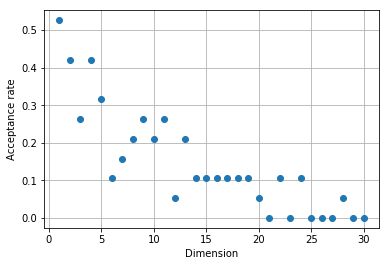

In [208]:
dimension = range(1,31)

plt.grid(True, which="both")

plt.plot(dimension,df_acc['acc_rate'],'o')
plt.title('Acceptance rate')
plt.xlabel('Dimension')
plt.ylabel('Acceptance rate')

plt.show()

We are interested in real rare events and with the choice of $Y_d$ right now, this probability increases by higher dimension. Let $\Phi(X) = \frac{\lVert X \rVert^2 - d}{\sqrt{2d}}$ If we define $\tilde{Y} = \frac{Y_d-d}{\sqrt{2d}}$ where $d$ still denotes the dimension (of $X$). Then $$\mathbb{P}(\tilde{Y} > L) = \mathbb{P}(Z > L)$$ where $Z$ denotes the standard normal distribution and remark that this probability is independent of the dimension. This solves the problem of increasing probability by increasing dimension, because for every dimension we are looking at rare event probabilities. Define a new score function $\Phi(X)$:

In [266]:
def Phi_2(x):
    """ Phi(x): R^d -> R"""
    return np.array([(np.dot(v,v)-len(v))/float(np.sqrt(2*(len(v)))) for v in x])

Another score function could be $\Phi(X) = c \lVert X \rVert^2$, but this wouldn't solve the problem of increasing probability by increasing dimension. On the other hand we know that $c \lVert X \rVert^2$ follows a gamma distribution, i.e., if $ X\sim \chi ^{2}(\nu )$ and $c>0$, then $cX\sim \Gamma(k = \nu/2, \theta = 2c)$. If I test this method for MH this still gives good estimates for the rare event probability. However, we still have the same problem as with the chi-squared distribution.

from scipy.stats import gamma
gamma.sf(4,a = 10./2,loc = 0,scale = 2*0.1)

In [330]:
def Phi_3(x):
    """ Phi(x): R^d -> R"""
    return np.array([0.1*(np.dot(v,v)) for v in x])

Suppose $\Phi(X) = \frac{\lVert X \rVert^2 - d}{\sqrt{2d}}$. We are again interested in the values for which $\Phi(X) = r$, because we need to bounce here. We use the same derivation as above, then

$$
\begin{align}
\Phi(X) & = \frac{\lVert X \rVert^2 - d}{\sqrt{2d}} = r\\
& \Leftrightarrow \Vert X \rVert^2 = \sqrt{2d}\cdot r+d \\
& \Leftrightarrow t^2(v\bullet v) + 2\cdot t\cdot (v\bullet x) + x\bullet x - \sqrt{2d}r+d = 0
\end{align}
$$

The only thing changed in the analysis is the value for the radius. We need to use this new radius in the computation time of the hitting time of the boundary.

In [461]:
def tau_bounce_sphere(x,v,r,C):
    d = len(x)
    #(np.sqrt(2*d)*r+d)**2 bps simulates correct value
    D = (2*(np.dot(v,x-C)))**2 - 4*np.dot(v,v)*(np.dot(x-C,x-C)-(np.sqrt(2*d)*r+d))
    if (D<0):
        tau = np.nan
    elif (D==0):
        tau = -(np.dot(v,x-C))/(np.dot(v,v))
    else:
        tau = min((-2*np.dot(v,x-C) + np.sqrt(D))/(2*np.dot(v,v)),(-2*np.dot(v,x-C) - np.sqrt(D))/(2*np.dot(v,v)))
    return tau

In [462]:
# Targeting multivariate normal distribution with mean [0,0] and variance [[1,0],[0,1]]
N = 100
T = 20
q = 4

mean = np.array([0,0])
cov = np.array([[1,0],[0,1]])

p2 = p_estimation_mnorm(N,T,q,mean,cov,Phi_2)

In [466]:
# Targeting normal distribution with mean 0 and variance 1
cov_prop = 2*np.eye(2)
mu_target = np.array(2*[0])
cov_target = np.eye(2)

p_1 = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_norm, target_fn_kwargs = {'mu':mu_target,'cov':cov_target},prop_fn_kwargs = {'cov':cov_prop})

In [468]:
from scipy.stats import norm
from scipy.stats import chi2

Compute the rare event probabilities for dimensions 1 to 5.

In [821]:
np.random.seed(205090)

N = 100
T = 20
q = 4
target_fn = normal
prop_fn = gaussian_proposal

columns = ['p','p_est_bs','time_bs','n_bs','p_est_mh','time_mh','n_mh']
dimension = range(1,6)

df_2 = pd.DataFrame(index = dimension, columns = columns)
df_2 = df_2.fillna(0)

for i in range(0,len(dimension)):
    cov_prop = 2*np.eye(dimension[i])
    mu_target = np.array([0]*dimension[i])
    cov_target = np.eye(dimension[i])
    
    # Time complexity mh-sampler
    start_mh = time.time()
    p_mh,m_mh = p_estimation(N,T,q,normal,gaussian_proposal,Phi = Phi_2, 
                                target_fn_kwargs = {'mu':mu_target,'cov':cov_target},
                                prop_fn_kwargs = {'cov':cov_prop})
    end_mh = time.time()
    
    # Time complexity bouncy-sampler
    start_bs = time.time()
    p_bs,m_bs = p_estimation_mnorm(N,T,q,mu_target,cov_target,Phi_2)
    end_bs = time.time()
    
    df_2.iloc[i,0] = chi2.sf(i+np.sqrt(2*i)*q)
    
    df_2.iloc[i,1] = p_bs
    df_2.iloc[i,2] = end_bs - start_bs
    df_2.iloc[i,3] = m_bs
    
    df_2.iloc[i,4] = p_mh
    df_2.iloc[i,5] = end_mh - start_mh
    df_2.iloc[i,6] = m_mh

TypeError: _parse_args() takes at least 2 arguments (1 given)

In [820]:
chi2.sf(100000+np.sqrt(2*100000)*4,df=100000)

3.4765792129073676e-05

In [ ]:
df_2

As can be seen in the table above, the estimates for BPS and MH are the same, but they do not seem to target the real rare event probability. Let's go a step back for a moment. We realized that $\Phi(X) = \lVert X \rVert^2$ (Phi_norm) follows a chi-squared distribution, so we compared the estimate with this true value. This worked pretty well. By using the CLT we found a distribution $\tilde{Y}$ that follows a standard normal distribution, so we have again a true value for the estimates.

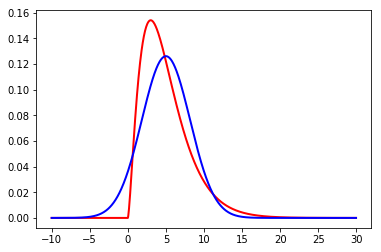

In [408]:
d = 5

x = np.arange(-10, 20, .05)
plt.plot(x, chi2.pdf(x, df=d), color='r', lw=2)
plt.plot(x, norm.pdf(x,loc=d,scale=np.sqrt(2*d)),color='b',lw=2)
plt.show()

It turns out that everything was just fine, the approximation of a chi-squared distribution by a normal distribution for lower dimension is bad.

#### Effective sample size

Our goal is to estimate $p = \mathbb{P}(\Phi(X)>L)$. Suppose there is a way to get i.i.d. sample from $X$. Denote $Y = \Phi(X)$, with mean $p$ and standard deviation $\sigma$. Then the mean of this distribution is estimated by the mean of the sample:

$$\hat{p} = \frac{1}{n}\sum_{i=1}^{n} 1_{y_i>L}$$

In the case, where all the $y_i$ are independent, the variance of $\hat{p}$ is given by

$$\text{Var}(\hat{p}) = \frac{1}{n}\text{Var}(1_{y_i>L})$$ However, if the observations in the sample are correlated, then $\text{Var}(\hat{p})$ is probably higher, which is the case in MCMC. The samples (processes) we create are not independent. Now, the effective sample size (ESS), $\hat{T}^S$, is the unique value such that

$$\text{Var}(\hat{p}) = \frac{\sigma^2}{\hat{T}^S}$$ and gives the size of an idd sample with the same variance as the current sample and thus indicates the loss in efficiency due to the use of a Markov chain (Robert and Casella, 2004). This value is computed as $$\hat{T}^S = T/\kappa(h)$$ where $\kappa(h)$ is the autocorrelation time associated with the sequence $h(\theta^{(t)})$, $$\kappa(h) = 1 + 2 \sum_{t=1}^{\infty} \text{corr}(h(\theta^{(0)}),h(\theta^{(t)}))$$

In [519]:
x0 = np.array([4.5])
dim = x0.size
mean = np.array([0]*dim)
cov = np.eye(dim)
cov_prop = 0.25*np.eye(dim)

target_fn_kwargs = {'mu':mean,'cov':cov}
prop_fn_kwargs = {'cov':cov_prop}

T = 1000

process,_,_ = mh_sampler(x0 = x0,target_fn = normal,prop_fn = gaussian_proposal,
               Phi = Phi_2,L = 4,iterations = T,target_fn_kwargs = target_fn_kwargs,
               prop_fn_kwargs = prop_fn_kwargs)

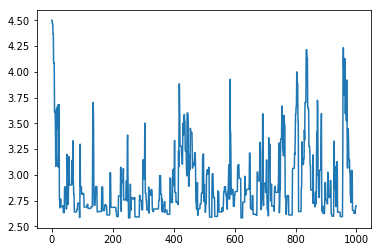

In [520]:
plt.plot(process)

In [548]:
flat_list = [item for sublist in process for item in sublist]

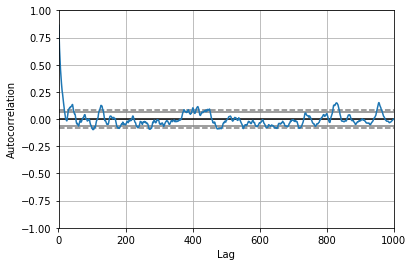

In [549]:
from pandas.plotting import autocorrelation_plot

plt.figure()

autocorrelation_plot(flat_list)


In [565]:
x0 = np.array([4.5])
dim = x0.size
mean = np.array([0]*dim)
cov = np.eye(dim)

T = 400

bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,2]))
_,process_bs,_ = bps.simulation

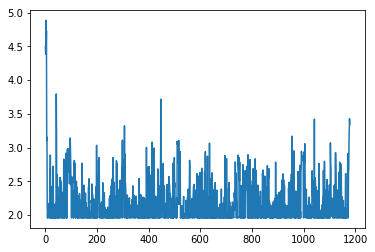

In [566]:
plt.plot(process_bs)

2.1213203435596424

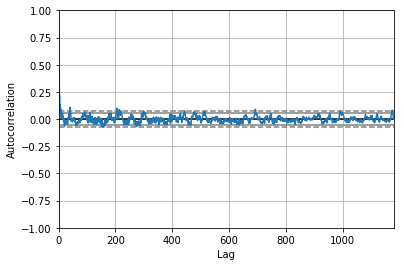

In [567]:
autocorrelation_plot(process_bs)

TypeError: 'AxesSubplot' object is not iterable

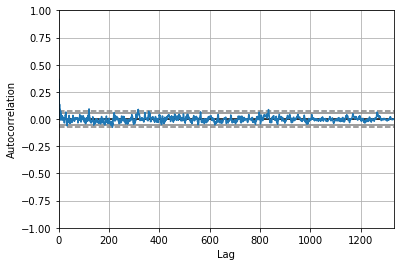

In [563]:
list(autocorrelation_plot(process_bs))

In [615]:
def acf(series,h):
    n = len(series)
    data = np.asarray(h(series))
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        acf_lag = ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return acf_lag
    x = np.arange(n) # Avoiding lag 0 calculation
    acf_coeffs = map(r, x)
    return acf_coeffs

In [616]:
def h(x):
    return x

In [617]:
def ESS(series):
    acf_coeffs = acf(series,h)
    n = len(process_bs)
    return n/float((1+2*sum(acf_coeffs[1:])))

Construct 10 chains of fixed length.

In [807]:
np.random.seed(239423849)

x0 = np.array([4.5])
dim = x0.size
mean = np.array([0]*dim)
cov = np.eye(dim)

T = 500

columns = range(1,1000)
index = range(1,11)

bps_chains = pd.DataFrame(index = index, columns = columns)

for i in range(1,11):
    bps = BPS(x0,dim,mean,cov,T,boundary = np.array([[0]*dim,2]))
    _,process_bs,_ = bps.simulation
    bps_chains.iloc[i-1,:] = process_bs.T.iloc[0,:]

In [803]:
mh_chains = pd.DataFrame(index = index, columns = columns)
T = 1000

for i in range(1,11):
    process,_,_ = mh_sampler(x0 = x0,target_fn = normal,prop_fn = gaussian_proposal,
               Phi = Phi_2,L = 2,iterations = T,target_fn_kwargs = target_fn_kwargs,
               prop_fn_kwargs = prop_fn_kwargs)
    
    x_star = process[-1]
    p_est = Phi_2([x_star])
    #print(pd.DataFrame(process))
    mh_chains.iloc[i-1,:] = pd.DataFrame(process).T.iloc[0,:]

In [804]:
mh_chains

,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
1,4.04841,4.03013,3.79457,3.79457,3.45227,3.5035,3.5035,2.75166,2.26352,2.08671,...,2.04013,2.04013,1.97873,1.97873,1.97873,1.97873,1.97873,2.19854,2.3218,2.3218
2,4.5,4.06225,3.09537,2.82915,2.82915,2.87323,2.87323,2.42368,2.21848,2.35057,...,2.04921,2.42627,2.42627,2.95321,2.85145,2.85145,3.17713,3.17713,2.19816,2.19816
3,3.88919,3.8855,3.03382,2.67566,2.67566,2.17227,2.79554,2.39591,2.39591,2.22354,...,2.01467,2.01467,2.62531,2.8299,2.56218,2.43897,2.45863,2.32615,2.38396,2.38396
4,4.5,4.5,4.64183,4.40807,4.40807,3.84707,3.37911,3.37911,3.37911,2.96328,...,2.62245,1.98084,2.31017,2.31017,2.14705,2.39782,2.39782,2.30582,2.30582,2.30582
5,4.53196,4.23861,4.1965,3.28054,3.14593,3.14593,3.14593,3.17204,3.21401,3.21401,...,2.10813,2.10813,2.10813,2.10813,2.22142,2.22142,2.48591,2.48591,2.48591,2.48591
6,4.43044,4.37182,4.34561,4.38517,4.46905,3.96584,4.72222,4.72222,4.61314,3.8265,...,2.32429,2.53361,2.38599,2.52986,2.31129,1.97653,1.97653,2.01145,2.01145,2.01145
7,4.37679,4.20958,4.20958,4.46487,4.42282,4.13101,4.17346,4.0814,3.61813,3.21296,...,2.19294,2.19294,2.1181,2.43905,2.08219,2.08138,2.08138,2.64753,2.59705,2.04037
8,4.46878,4.06903,4.06903,4.06903,3.43166,3.44972,3.61393,3.08523,2.93488,2.93488,...,2.25677,2.28272,2.4255,2.69828,2.67656,2.67656,2.57667,2.03218,2.00066,2.27029
9,3.89442,4.06468,3.8159,3.71793,3.71793,3.71793,3.76604,3.76604,3.22384,3.22384,...,2.73025,2.73025,2.73025,2.25013,2.54864,2.59214,2.12825,2.2332,2.2332,2.2332
10,4.5,4.5,4.5,4.27819,3.41055,3.56983,3.59309,3.59309,3.59309,3.59309,...,3.63742,3.63742,3.63742,3.33535,2.66944,3.01717,3.01717,2.52251,2.18621,2.18621


In [778]:
bps_chains

,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
1,4.5,4.18732,4.18649,4.16534,3.70911,2.63262,2.92905,2.89584,2.89046,1.95664,...,2.1994,1.95664,2.33352,1.95664,1.96357,1.95664,3.68552,3.53403,3.28532,3.21765
2,4.5,4.79534,4.65253,4.64585,3.52285,3.61807,3.61226,3.66177,3.63228,3.41604,...,2.38045,1.95664,1.96541,1.95664,2.24411,2.23556,2.31013,1.95664,2.50281,1.95664
3,4.5,4.48129,1.95664,1.97414,1.95664,2.69499,2.26488,1.95664,2.84417,1.95664,...,1.95664,2.47876,1.95664,2.04346,1.95664,2.17196,1.95664,2.4938,1.95664,2.26342
4,4.5,4.51825,4.09895,4.1892,4.17739,4.03916,4.0543,2.58327,2.54426,2.87058,...,2.89611,1.95664,2.1429,1.95664,2.06579,1.95664,2.22885,1.95664,2.24664,2.43713
5,4.5,4.40118,2.56392,2.59893,1.95664,2.11633,1.95664,2.15927,2.03412,2.46944,...,1.95664,2.35781,1.95664,2.6648,1.95664,2.05057,1.95664,2.16225,1.95664,2.09218
6,4.5,4.47621,3.52876,2.94126,2.75231,2.71977,2.3274,2.88035,3.26969,2.70787,...,1.95664,2.11479,2.31337,1.95664,2.02286,1.95664,2.45792,1.95664,2.15074,1.95664
7,4.5,4.11043,4.19656,4.22211,4.33689,3.9226,4.22581,3.60328,3.66591,3.68033,...,1.95664,2.07553,2.13958,2.48785,2.48195,1.95664,2.18555,1.95664,2.51879,1.95664
8,4.5,4.35111,3.77428,3.80792,2.38711,2.08179,1.95664,1.98282,1.95664,2.0166,...,2.32938,1.95664,2.18841,2.08434,2.21658,1.95664,2.74757,2.59953,2.45258,2.36861
9,4.5,4.48611,4.58098,3.97444,3.9775,3.93062,2.98909,2.97805,1.95664,2.03498,...,2.15258,1.95664,2.04671,2.31882,1.95664,2.15486,2.29735,2.18897,2.22246,1.95664
10,4.5,4.36287,1.95664,2.37355,1.96225,2.20476,2.67852,2.84891,2.34723,1.95664,...,2.29738,1.95664,2.10275,2.05359,1.96411,2.17772,2.0212,2.52056,2.47696,1.95664


In [779]:
def my_gelman_rubin(x):
    """ Estimate the marginal posterior variance. Vectorised implementation. """
    m_chains, n_iters = x.shape

    # Calculate between-chain variance
    B_over_n = ((np.mean(x, axis=1) - np.nanmean(x))**2).sum() / (m_chains - 1)

    # Calculate within-chain variances
    W = ((x.sub(np.mean(x, axis=1), axis=0))**2).values.sum() / (m_chains*(n_iters - 1))

    # (over) estimate of variance
    s2 = W * (n_iters - 1) / n_iters + B_over_n

    return s2

In [780]:
def my_ESS(x):
    """ Compute the effective sample size of estimand of interest. Vectorised implementation. """
    m_chains, n_iters = x.shape

    variogram = lambda t: ((x.iloc[:, t:].values - x.iloc[:, :(n_iters - t)].values)**2).sum() / (m_chains * (n_iters - t))
    
    post_var = my_gelman_rubin(x)

    t = 1
    rho = np.ones(n_iters)
    negative_autocorr = False

    # Iterate until the sum of consecutive estimates of autocorrelation is negative
    while not negative_autocorr and (t < n_iters):
        rho[t] = 1 - variogram(t) / (2 * post_var)

        if not t % 2:
            negative_autocorr = sum(rho[t-1:t+1]) < 0

        t += 1

    return int(m_chains*n_iters / (1 + 2*rho[1:t].sum()))

In [781]:
my_ESS(bps_chains)

214

In [805]:
my_ESS(mh_chains)

334